# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

Признаки:

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — количество недвижимости у клиента

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата


Целевой признак:

Exited — факт ухода клиента

# 1. Подготовка данных

# 1.1 Загрузка данных

In [1]:
#Подключим библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 


#Откроем файл
data = pd.read_csv('/datasets/Churn.csv')

#Отобразим первые 5 строк таблицы
display(data.head(5))

#Отобразим размер таблицы
print('Размер таблицы:')
display(data.shape)

#Просмотрим общую информации о таблице
print('Общая информация о таблице:')
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Размер таблицы:


(10000, 14)

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


# 1.2 Заменим значения 'nan' в столбце 'Tenure' на медианые значения

In [2]:
#Так в столбце 'Tenure' есть значения 'nan', то их необходимо заполнить
#Так как таких значений порядка 900 шт. и это 9% данных, то заменить их на ноль будет не корректно.
#Поэтому будем заменять их на значение медианы. 
print("До замены nan:")
display(data['Tenure'].unique())
display(data['Tenure'].sort_values(ascending=True).value_counts())

mediana_tenure = data['Tenure'].median() #вычислим медиану
data['Tenure'] = data['Tenure'].fillna(mediana_tenure) #заменим 'nan' на медианные значения.

print("После замены nan:")
display(data['Tenure'].unique())
display(data['Tenure'].sort_values(ascending=True).value_counts())

До замены nan:


array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

После замены nan:


array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: Tenure, dtype: int64

# 1.3 Удалим столбец 'Surname'

In [3]:
#Удалим столбец Surname, так как он объектоного типа и не относится к признакам.
print(data.dtypes)
data.drop('Surname', axis=1, inplace=True)

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


# 1.4 Вывод:

Таблица содержит 1000 строк и 14 столбцов. Столбец 'Tenure' содержад пропуски, в связи с чем, пропуски были заменены на медианные значения. Столбец Surname был удален, так как он объектоного типа и не относится к признакам.

# 2. Исследование задачи

# 2.1 Исследуем баланс классов

0    0.7963
1    0.2037
Name: Exited, dtype: float64


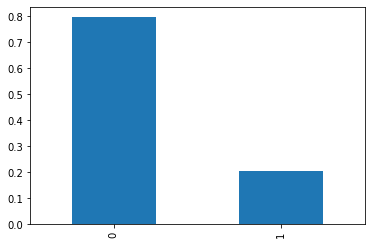

In [4]:
## Исследуем баланс классов и построим график
class_frequency = data['Exited'].value_counts(normalize = True)
print(class_frequency)

#Построим график
class_frequency.plot(kind='bar')

# 2.2 Вывод:

Наблюдается дисбаланс классов, значений 1 - 20%, в значений 0 - 80%. В связи с чем, пользоваться Accuracy для оценки модели не представляется возможным. Для оценки модели будем использовать параметр f1. 

# 2.3 Изучим модели без учета дисбаланса

# 2.3.1 Линейная регрессия без учета дисбаланса

In [5]:
pd.options.mode.chained_assignment = None #отключим warning

#Преобразуем категориальный признак техникой OHE
data_ohe = pd.get_dummies(data, drop_first=True)

#Определим признаки и целевой признак для модели линейная регрессия
target_ohe = data_ohe['Exited']
features_ohe = data_ohe.drop(['RowNumber', 'CustomerId', 'Exited'], axis=1)

#Выделим 20% тестовых данных из всего объема данных
features_df1, features_test_ohe, target_df1, target_test_ohe = train_test_split(features_ohe, target_ohe, test_size=0.20, random_state=12345)

#Разделим отавшиеся 80% данных на тренировочные и валидационные(проверечное). Данные делим в пропорции: 75% от общего числа
#данных - это тренировочные, 25% от общего числа - это валидационные.
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_df1, target_df1, test_size=0.25, random_state=12345)

#Выполним масштабирование для модели линейная регрессия
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'] #определим столбцы, которые будем масштабировать
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric]) 
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric]) 
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric]) 

#Проверим модель линейная регрессии
model = LogisticRegression(random_state=12345, solver='liblinear')#создадим модель и установим гиперпараметры
model.fit(features_train_ohe[numeric], target_train_ohe) #обучим модель на тренировочной выборке
predicted_valid_ohe = model.predict(features_valid_ohe[numeric]) #предскажем на валидационной выборке
print('f1_score:', f1_score(target_valid_ohe, predicted_valid_ohe)) #вычислим f1

f1_score: 0.25301204819277107


# 2.3.2 AUC-ROC для логистической регрессия без учета дисбаланса

AUC-ROC логистической регрессии: 0.748329012476177


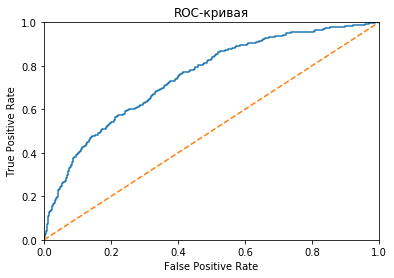

In [6]:
#Вычислим AUC-ROC
probabilities_valid_ohe = model.predict_proba(features_valid_ohe[numeric])
probabilities_one_valid_ohe = probabilities_valid_ohe[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid_ohe)
print('AUC-ROC логистической регрессии:', auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid_ohe) 

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 2.3.3 Случайный лес без учета дисбаланса

In [7]:
#Определим признаки и целевой признак для модели случайный лес
target= data['Exited'] 
features = data.drop(['RowNumber', 'CustomerId', 'Exited'], axis=1) #исключим из признаков 'RowNumber', 'CustomerId', 'Exited'

#Выделим 20% тестовых данных из всего объема данных
features_df1, features_test, target_df1, target_test = train_test_split(features, target, test_size=0.20, random_state=12345)

#Разделим отавшиеся 80% данных на тренировочные и валидационные(проверечное). Данные делим в пропорции: 75% от общего числа
#данных - это тренировочные, 25% от общего числа - это валидационные.
features_train, features_valid, target_train, target_valid = train_test_split(features_df1, target_df1, test_size=0.25, random_state=12345)

#Выполним масштабирование для модели случайный лес
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'] #определим столбцы, которые будем масштабировать
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

#Напишем функцию для модели 'случайный лес', чтобы выбрать лучшую модель в зависимости от количества деревьев и глубины.
best_model = None
best_result = 0
for est in range(1, 50):
    for depth in range(1,50):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, criterion = 'entropy', min_samples_split=3, min_samples_leaf=1) #установим гиперпараметры
        model.fit(features_train[numeric], target_train) # обучим модель на тренировочной выборке
        result = model.score(features_valid[numeric], target_valid) # посчитаем accuracy модели на валидационной выборке
        if result > best_result:
            best_model = model
            best_result = result
            
print("Accuracy наилучшей модели 'случайный лес' на валидационной выборке:", best_result)
print("Лучшая модели 'случайный лес' на валидационной выборке:", best_model)

#Вычислим f1 для лучшей модели 'случайный лес'
model = RandomForestClassifier(random_state=12345, max_depth=11, n_estimators=27, criterion = 'entropy', min_samples_split=3, min_samples_leaf=1) #установим гиперпараметры
model.fit(features_train[numeric], target_train) # обучим модель на тренировочной выборке
predicted_valid = model.predict(features_valid[numeric]) #предскажем на масштабированной валидационной выборке
print("F1_score:", f1_score(target_valid, predicted_valid))

Accuracy наилучшей модели 'случайный лес' на валидационной выборке: 0.8615
Лучшая модели 'случайный лес' на валидационной выборке: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=27,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
F1_score: 0.534453781512605


# 2.3.4 AUC-ROC для модели случайный лес без учета дисбаланса

AUC-ROC модели случайный лес: 0.8334957297427037


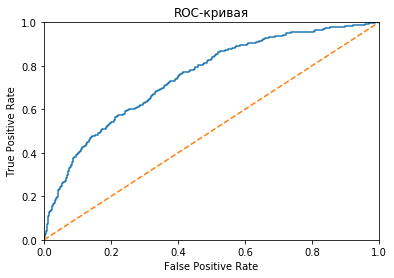

In [8]:
#AUC-ROC
probabilities_valid = model.predict_proba(features_valid[numeric])
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели случайный лес:', auc_roc)

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 2.4 Вывод:

Были исследованы модели 'линейная регрессия' и 'случайный лес' без учета дисбаланса. Для линейной регрессии преобразовали категориальные признаки в численные с помощью техника прямого кодирования One-Hot Encoding (OHE) и чтобы не попасть в дамми-ловушку было указан аргумент drop_first = True и применен метод масштабирования.
Для модели 'случайный лес' была примененена функция порядковое кодирование, в результате категориальные признаки были преобразованы в цифры и применен метод масштабирования.
Если не бороться с дисбалансом, то f1 у линейной регрессии очень низкий и равен 0.25301204819277107. У модели случайный лес f1, гораздо выше и составляет F1_score: 0.534453781512605, но необходимо достичь 0,59. Лучшего результата у модели случайный лес достигается с использованием гиперпараметров max_depth=11, n_estimators=27, criterion = 'entropy'.

# 3. Борьба с дисбалансом

# 3.1 Взвешивание классов для логистической регрессии 

f1_score: 0.45654082528533807
AUC-ROC логистической регрессии: 0.7525205883147703


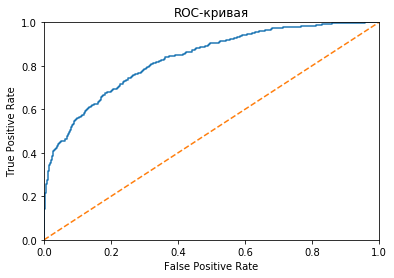

In [9]:
#Установим гиперпараметр class_weight='balanced' для балансировки классов и проверим модель на валидационной выборке
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')#создадим модель и установим гиперпараметры
model.fit(features_train_ohe[numeric], target_train_ohe) #обучим модель на тренировочной выборке
predicted_valid_ohe = model.predict(features_valid_ohe[numeric]) #предскажем на валидационной выборке
print('f1_score:', f1_score(target_valid_ohe, predicted_valid_ohe)) #вычислим f1


#Вычислим AUC-ROC
probabilities_valid_ohe = model.predict_proba(features_valid_ohe[numeric])
probabilities_one_valid_ohe = probabilities_valid_ohe[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid_ohe)
print('AUC-ROC логистической регрессии:', auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid) 

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 3.2 Взвешивание классов для модели случайный лес

F1_score: 0.5431472081218274
AUC-ROC модели случайный лес: 0.8264811585725436


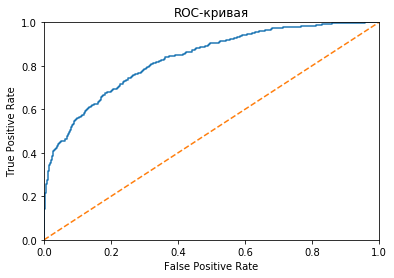

In [10]:
#Установим гиперпараметр class_weight='balanced' для балансировки классов и проверим модель на валидационной выборке
model = RandomForestClassifier(random_state=12345, max_depth=11, n_estimators=27, criterion = 'entropy', min_samples_split=3, min_samples_leaf=1, class_weight='balanced') #установим гиперпараметры
model.fit(features_train[numeric], target_train) # обучим модель на тренировочной выборке
predicted_valid = model.predict(features_valid[numeric]) #предскажем на масштабированной валидационной выборке
print("F1_score:", f1_score(target_valid, predicted_valid))#вычислим f1 для лучшей модели 'случайный лес'

#AUC-ROC
probabilities_valid = model.predict_proba(features_valid[numeric])
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели случайный лес:', auc_roc)

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 3.3 Увелечение выборки для логистической регрессии

In [11]:
#Увеличим выборку с помощью техники upsampling 
def upsample(features_ohe, target_ohe, repeat):
    features_zeros_ohe = features_ohe[target_ohe == 0]
    features_ones_ohe = features_ohe[target_ohe == 1]
    target_zeros_ohe = target_ohe[target_ohe == 0]
    target_ones_ohe = target_ohe[target_ohe == 1]

    features_upsampled_ohe = pd.concat([features_zeros_ohe] + [features_ones_ohe] * repeat)
    target_upsampled_ohe = pd.concat([target_zeros_ohe] + [target_ones_ohe] * repeat)
    
    features_upsampled_ohe, target_upsampled_ohe = shuffle(
        features_upsampled_ohe, target_upsampled_ohe, random_state=12345)
    
    return features_upsampled_ohe, target_upsampled_ohe

features_upsampled_ohe, target_upsampled_ohe = upsample(features_train_ohe[numeric], target_train_ohe, 10)

# 3.4 Проверка модели логистическая регрессии на увеличенной выборке

f1_score на увеличенной выборке логистической регрессии: 0.39300847457627114
AUC-ROC логистической регрессии: 0.754192767981892


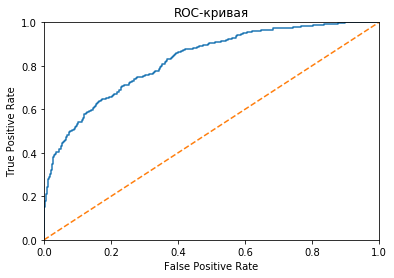

In [12]:
#Проверим модель логистической регрессии на увеличенной выборке
model = LogisticRegression(random_state=12345, solver='liblinear')#создадим модель и установим гиперпараметры
model.fit(features_upsampled_ohe, target_upsampled_ohe) #обучим модель на увеличенной выборке
predicted_valid_ohe = model.predict(features_valid_ohe[numeric]) #предскажем на валидационной выборке
print('f1_score на увеличенной выборке логистической регрессии:', f1_score(target_valid_ohe, predicted_valid_ohe)) #вычислим f1

#Вычислим AUC-ROC
probabilities_valid_ohe = model.predict_proba(features_valid_ohe[numeric])
probabilities_one_valid_ohe = probabilities_valid_ohe[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid_ohe)
print('AUC-ROC логистической регрессии:', auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid) 

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 3.5 Проверка модель логистической регрессии на увеличенной выборке и взвешанных классах

f1_score на увеличенной выборке и взвешанных классах логистической регрессии: 0.45654082528533807
AUC-ROC логистической регрессии: 0.7525126406927783


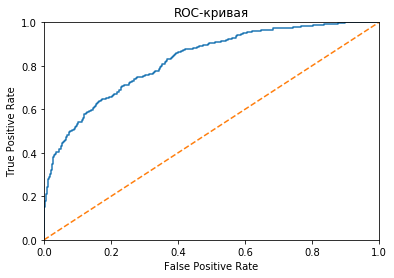

In [13]:
#Проверим модель логистической регрессии на увеличенной выборке
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')#создадим модель и установим гиперпараметры
model.fit(features_upsampled_ohe, target_upsampled_ohe) #обучим модель на увеличенной выборке
predicted_valid_ohe = model.predict(features_valid_ohe[numeric]) #предскажем на валидационной выборке
print('f1_score на увеличенной выборке и взвешанных классах логистической регрессии:', f1_score(target_valid_ohe, predicted_valid_ohe)) #вычислим f1

#Вычислим AUC-ROC
probabilities_valid_ohe = model.predict_proba(features_valid_ohe[numeric])
probabilities_one_valid_ohe = probabilities_valid_ohe[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid_ohe)
print('AUC-ROC логистической регрессии:', auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid) 

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 3.6 Увелечение выборки для модели случайный лес

In [14]:
#Увеличим выборку с помощью техники upsampling 
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train[numeric], target_train, 10)

# 3.7 Проверка модели случайный лес на увеличенной выборке

f1_score на увеличенной выборке модели случайный лес: 0.4907183212267958
AUC-ROC модели случайный лес: 0.8238616223639725


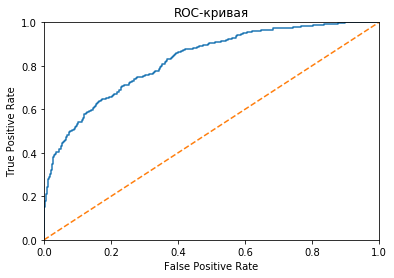

In [15]:
#Проверим модель случайный лес на увеличенной выборке
model = RandomForestClassifier(random_state=12345, max_depth=11, n_estimators=27, criterion = 'entropy', min_samples_split=3, min_samples_leaf=1) #установим гиперпараметры
model.fit(features_upsampled, target_upsampled) # обучим модель на увеличенной выборке
predicted_valid = model.predict(features_valid[numeric])#предскажем на валидационной выборке
print("f1_score на увеличенной выборке модели случайный лес:", f1_score(target_valid, predicted_valid)) #вычислим f1

#AUC-ROC
probabilities_valid = model.predict_proba(features_valid[numeric])
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели случайный лес:', auc_roc)

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 3.8 Проверка модели случайный лес на увеличенной выборке и взвешанных классах

f1_score на увеличенной выборке и взвешанных классах модели случайный лес: 0.5519630484988453
AUC-ROC модели случайный лес: 0.832561884158641


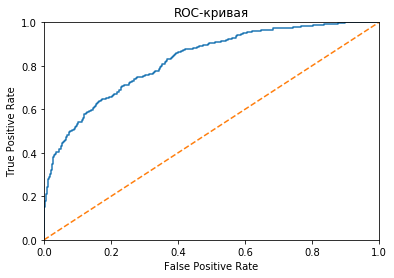

In [16]:
#Проверим модель случайный лес на увеличенной выборке и взвешанных классах (class_weight='balanced')
model = RandomForestClassifier(random_state=12345, max_depth=11, n_estimators=27, criterion = 'entropy', min_samples_split=3, min_samples_leaf=1, class_weight='balanced') #установим гиперпараметры
model.fit(features_upsampled, target_upsampled) # обучим модель на увеличенной выборке
predicted_valid = model.predict(features_valid[numeric])#предскажем на валидационной выборке
print("f1_score на увеличенной выборке и взвешанных классах модели случайный лес:", f1_score(target_valid, predicted_valid)) #вычислим f1

#AUC-ROC
probabilities_valid = model.predict_proba(features_valid[numeric])
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели случайный лес:', auc_roc)

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 3.9 Вывод:

Для борьбы с дисбалансом были применены методы взешивание классов и увеличение выборки. 

Для модели логистическая регрессия получили следущие результаты f1:

Взвешивание классов - 0.45654082528533807

Увеличение выборки - 0.39300847457627114

Взвешиваение классов совместно с увеличением выборки - 0.45654082528533807

Для модели случайный лес получили следущие результаты:

Взвешивание классов - 0.5431472081218274

Увеличение выборки - 0.4907183212267958

Взвешиваение классов совместно с увеличением выборки - 0.5519630484988453

Для логистической регрессии и случайного леса взвешивание классов дает больший прирост значения f1. Но еще больший прирост дает совместное использование методов взвешивания классов и увеличение выборки.

# 4. Тестирование модели

# 4.1 Тестирование логистической регрессии с использованием увеличенной выборки и взвешанных классов

In [17]:
#Проверим модель линейной регрессии с увеличенной выборкой и взвешаных классах на тестовой выборке
model = LogisticRegression(random_state = 12345, solver='liblinear', class_weight='balanced')
model.fit(features_upsampled_ohe, target_upsampled_ohe) #обучим модель на увеличенной выборке
predicted_test_ohe = model.predict(features_test_ohe[numeric]) #предскажем на валидационной выборке
print('f1_score на увеличенной выборке и взвешанных классах логистической регрессии:', f1_score(target_test_ohe, predicted_test_ohe)) #вычислим f1

f1_score на увеличенной выборке и взвешанных классах логистической регрессии: 0.46829268292682924


# 4.2 AUC-ROC для логистической регрессии

AUC-ROC логистической регрессии: 0.7525126406927783


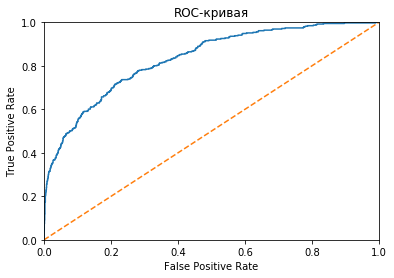

In [18]:
#Вычисллим AUC-ROC
probabilities_valid_ohe = model.predict_proba(features_valid_ohe[numeric])
probabilities_one_valid_ohe = probabilities_valid_ohe[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid_ohe)
print('AUC-ROC логистической регрессии:', auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid) 

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 4.3 Тестирование модели случайный лес с использованием увеличенной выборки и взвешанных классов.

In [19]:
#Проверим модель случайный лес с увеличенной выборкой и взвешаных классах на тестовой выборке
model = RandomForestClassifier(random_state=12345, max_depth=11, n_estimators=27, criterion = 'entropy', min_samples_split=3, min_samples_leaf=1, class_weight='balanced') #установим гиперпараметры
model.fit(features_upsampled, target_upsampled) #обучим модель на тренировочной выборке
predicted_test = model.predict(features_test[numeric]) #предскажем на тестовой выборке
print("F1_score модели случайный лес на тестовой выборке:", f1_score(target_test, predicted_test)) #вычислим f1

F1_score модели случайный лес на тестовой выборке: 0.6091586794462195


# 4.4 AUC-ROC для модели случайный лес

AUC-ROC модели случайный лес: 0.832561884158641


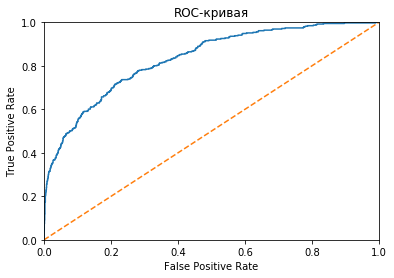

In [20]:
#AUC-ROC
probabilities_valid = model.predict_proba(features_valid[numeric])
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели случайный лес:', auc_roc)

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

# 4.5 Вывод:

С помощью модели случаный лес с использованием масштабирования, увеличения выборки и взвешивания классов при max_depth=11 и  n_estimators=27 удалось достичь значения f1 равное 0.6091586794462195 и AUC-ROC = 0.832561884158641. При тестирование модели логистической регрессии с использованием увеличенной выборки и взвешанных классов удалось достичь значения f1=0.46829268292682924 и AUC-ROC = 0.7525126406927783. Делаем вывод, что для решения текущего задчи логистическая регрессия не подходит.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*